In [2]:
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP
from Bio.PDB import PDBIO

import gzip
import pickle
import csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from DSSPparser import parseDSSP

import concurrent.futures
import subprocess
import random

import os
import shutil
import gzip
import zipfile
import pickle

import Modules.TORSION2 as TORSION2

from tqdm import tqdm

from concurrent.futures import ThreadPoolExecutor, as_completed
from argparse import ArgumentParser

from scipy.spatial.distance import pdist, squareform

import Modules.CROSSLINK as CROSSLINK
import Modules.TORSION2 as TORSION2
import Modules.UTILLS as UTILLS
import Modules.SOLVENTACC as SOLVENTACC

import warnings
warnings.filterwarnings("ignore")

2024-08-12 10:15:39.144458: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-12 10:15:39.200130: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 10:15:40.152920: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
file_path = './240808_AlphaLink_result.xlsx'
xls = pd.ExcelFile(file_path)
print(xls.sheet_names)

['Low neff CAMEO', 'CASP14 CAMEO Neff10', 'CASP14 CAMEO No MSA', 'FDR Experiment', 'Neff Experiment']


In [4]:
neff10 = pd.read_excel(file_path, sheet_name='CASP14 CAMEO Neff10', header = None)
neff0 = pd.read_excel(file_path, sheet_name= 'CASP14 CAMEO No MSA', header = None)

In [5]:
residue_lengths = {}
fasta_root = './231106_Alphalink_bk/240129_CASP14_15_data/fasta/'
fastas = os.listdir(fasta_root)
for fasta_file in fastas:
    with open(os.path.join(fasta_root, fasta_file), 'r') as file:
        lines = file.readlines()
        sequence = ''.join(line.strip() for line in lines if not line.startswith('>'))
        residue_lengths[fasta_file.split('.fasta')[0]] = len(sequence)

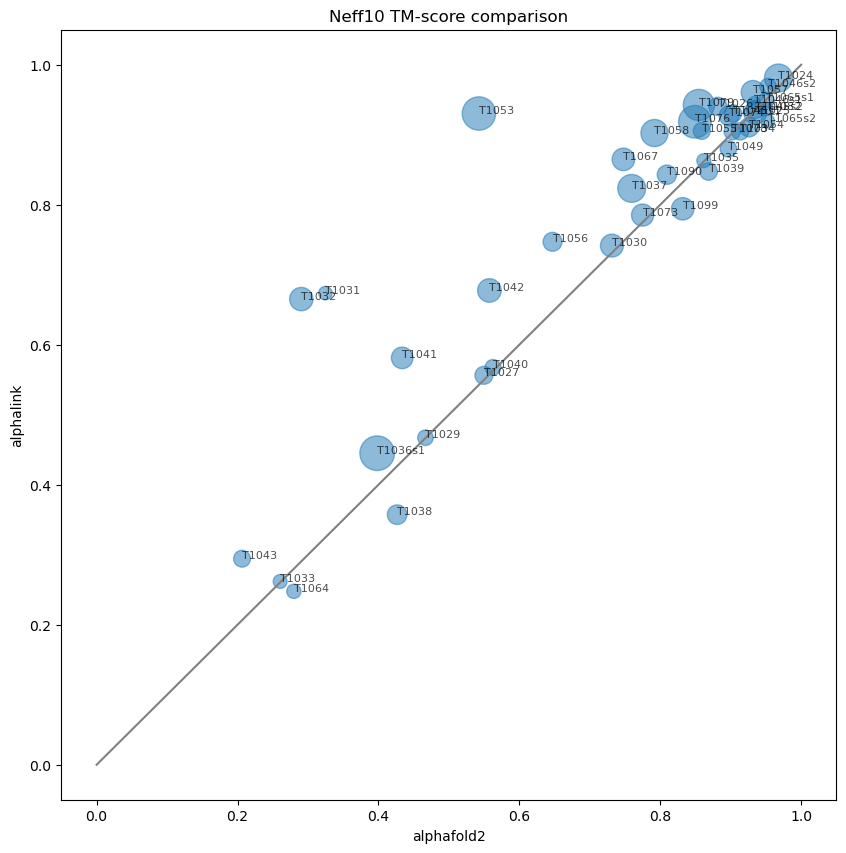

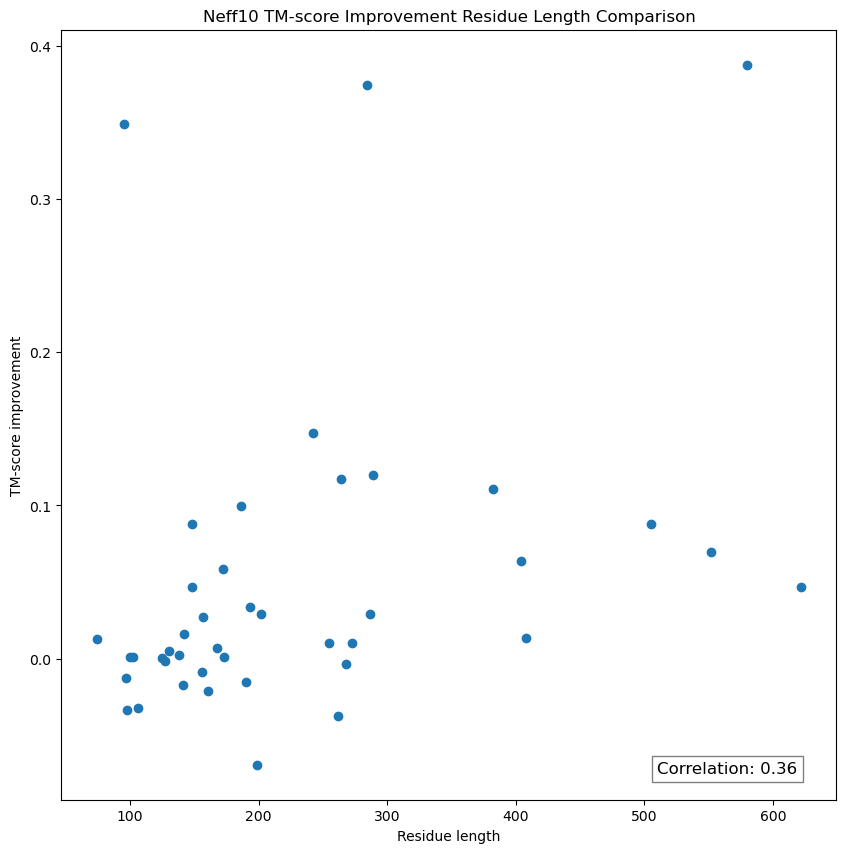

In [6]:
neff10_Alphalink_result, neff10_AlphaFold2_result = neff10[9].values, neff10[10].values
alphalink = {}
alphafold2= {}
for i in range(len(neff10_Alphalink_result)):
    alphalink_result = neff10_Alphalink_result[i]
    alphafold_result = neff10_AlphaFold2_result[i]
    
    target = alphalink_result.split('_')[0][1:]
    if target not in residue_lengths.keys() : continue
        
    alphalink_tmscore = float(alphalink_result.split('_')[-1].split('=')[-1])
    alphafold2_tmscore = float(alphafold_result.split('_')[-1].split('=')[-1])
    
    alphalink[target] = alphalink_tmscore
    alphafold2[target] = alphafold2_tmscore
sizes = [residue_lengths[key] for key in alphafold2.keys()]

plt.figure(figsize=(10, 10))
plt.title('Neff10 TM-score comparison')
scatter = plt.scatter(list(alphafold2.values()), list(alphalink.values()), s=sizes, alpha=0.5)
plt.plot([0, 1], [0, 1], color='gray')
plt.xlabel('alphafold2')
plt.ylabel('alphalink')

# Annotate each point with the corresponding key
for key, x, y in zip(alphafold2.keys(), alphafold2.values(), alphalink.values()):
    plt.annotate(key.strip(), (x, y), fontsize=8, alpha=0.7)

plt.show()    


plt.figure(figsize=(10, 10))
plt.title('Neff10 TM-score Improvement Residue Length Comparison')

# Calculate TM-score improvement
TM_score_improvement = []
for i in range(len(alphalink.values())):
    TM_score_improvement.append(list(alphalink.values())[i] - list(alphafold2.values())[i])

# Create scatter plot
plt.scatter(sizes, TM_score_improvement)
plt.xlabel('Residue length')
plt.ylabel('TM-score improvement')

# Annotate each point with the corresponding key
for key, x, y in zip(alphafold2.keys(), TM_score_improvement, residue_lengths.values()):
    plt.annotate(key.strip(), (x, y), fontsize=8, alpha=0.7)

# Calculate correlation coefficient
correlation_coef = np.corrcoef(sizes, TM_score_improvement)[0, 1]

# Display correlation coefficient on the plot
plt.text(0.95, 0.05, f'Correlation: {correlation_coef:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', 
         horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

plt.show()

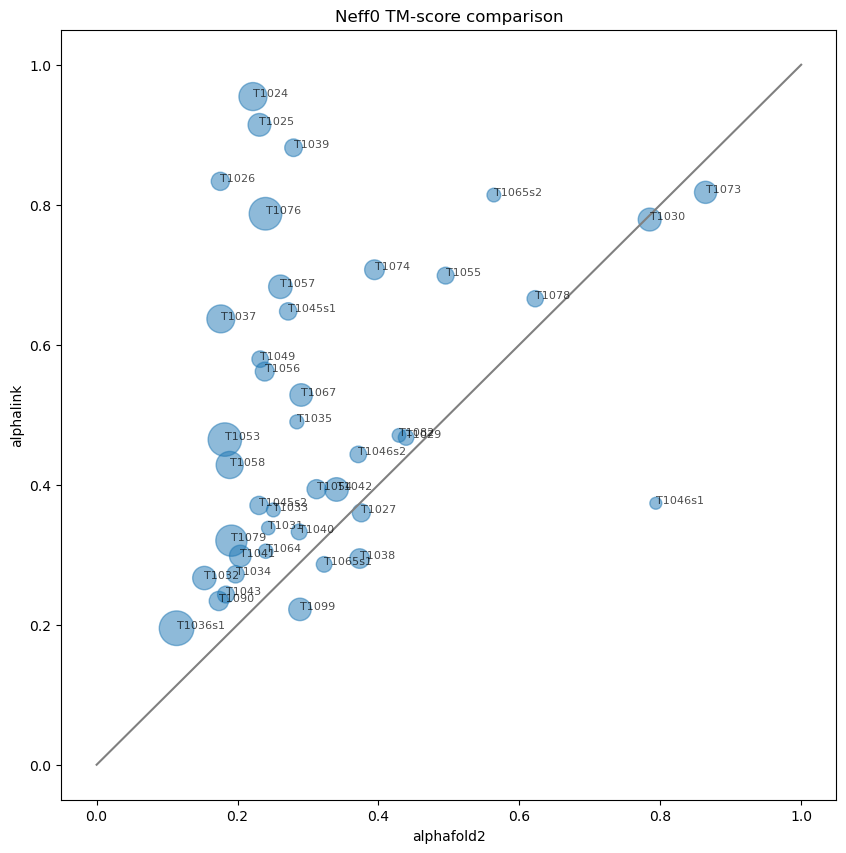

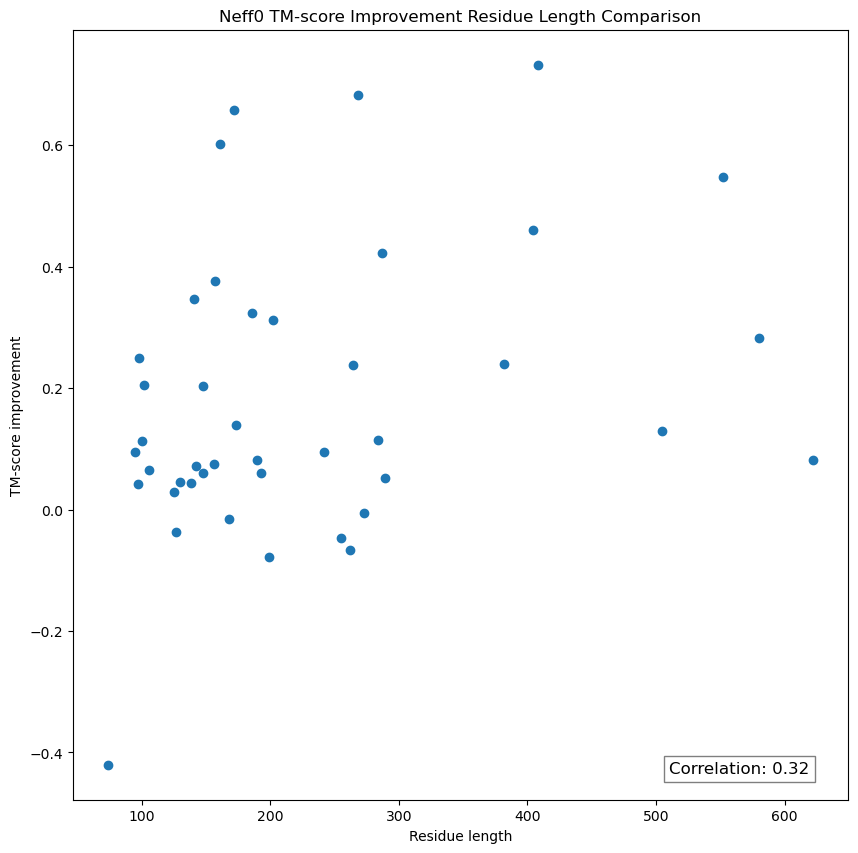

In [7]:
neff0_Alphalink_result, neff0_AlphaFold2_result = neff0[9].values, neff0[10].values
alphalink = {}
alphafold2= {}
for i in range(len(neff10_Alphalink_result)):
    alphalink_result = neff0_Alphalink_result[i]
    alphafold_result = neff0_AlphaFold2_result[i]
    
    target = alphalink_result.split('_')[0][1:]
    if target not in residue_lengths.keys() : continue
    
    alphalink_tmscore = float(alphalink_result.split('_')[-1].split('=')[-1])
    alphafold2_tmscore = float(alphafold_result.split('_')[-1].split('=')[-1])
    
    alphalink[target] = alphalink_tmscore
    alphafold2[target] = alphafold2_tmscore
sizes = [residue_lengths[key] for key in alphafold2.keys()]

plt.figure(figsize=(10, 10))
plt.title('Neff0 TM-score comparison')
scatter = plt.scatter(list(alphafold2.values()), list(alphalink.values()), s=sizes, alpha=0.5)
plt.plot([0, 1], [0, 1], color='gray')
plt.xlabel('alphafold2')
plt.ylabel('alphalink')

# Annotate each point with the corresponding key
for key, x, y in zip(alphafold2.keys(), alphafold2.values(), alphalink.values()):
    plt.annotate(key.strip(), (x, y), fontsize=8, alpha=0.7)

plt.show()    


plt.figure(figsize=(10, 10))
plt.title('Neff0 TM-score Improvement Residue Length Comparison')

# Calculate TM-score improvement
TM_score_improvement = []
for i in range(len(alphalink.values())):
    TM_score_improvement.append(list(alphalink.values())[i] - list(alphafold2.values())[i])

# Create scatter plot
plt.scatter(sizes, TM_score_improvement)
plt.xlabel('Residue length')
plt.ylabel('TM-score improvement')

# Annotate each point with the corresponding key
for key, x, y in zip(alphafold2.keys(), TM_score_improvement, residue_lengths.values()):
    plt.annotate(key.strip(), (x, y), fontsize=8, alpha=0.7)

# Calculate correlation coefficient
correlation_coef = np.corrcoef(sizes, TM_score_improvement)[0, 1]

# Display correlation coefficient on the plot
plt.text(0.95, 0.05, f'Correlation: {correlation_coef:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', 
         horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

plt.show()


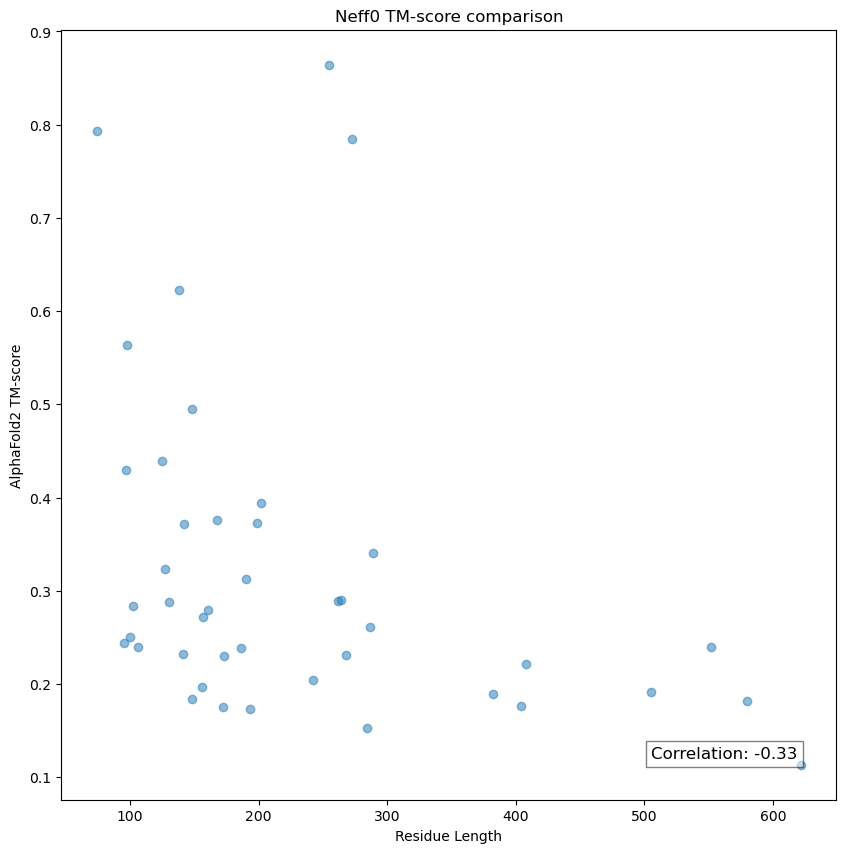

In [16]:
neff0_Alphalink_result, neff0_AlphaFold2_result = neff0[9].values, neff0[10].values

alphalink = {}
alphafold2 = {}
for i in range(len(neff0_Alphalink_result)):
    alphalink_result = neff0_Alphalink_result[i]
    alphafold_result = neff0_AlphaFold2_result[i]
    
    target = alphalink_result.split('_')[0][1:]
    if target not in residue_lengths.keys():
        continue
    
    alphalink_tmscore = float(alphalink_result.split('_')[-1].split('=')[-1])
    alphafold2_tmscore = float(alphafold_result.split('_')[-1].split('=')[-1])
    
    alphalink[target] = alphalink_tmscore
    alphafold2[target] = alphafold2_tmscore

sizes = [residue_lengths[key] for key in alphafold2.keys()]

# 상관계수 계산
correlation_coef = np.corrcoef(sizes, list(alphafold2.values()))[0, 1]

# 플롯 그리기
plt.figure(figsize=(10, 10))
plt.title('Neff0 TM-score comparison')
scatter = plt.scatter(sizes, list(alphafold2.values()), alpha=0.5)
plt.xlabel('Residue Length')
plt.ylabel('AlphaFold2 TM-score')

# 상관계수를 플롯의 우측 상단에 표시
plt.text(0.95, 0.05, f'Correlation: {correlation_coef:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', 
         horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

plt.show()

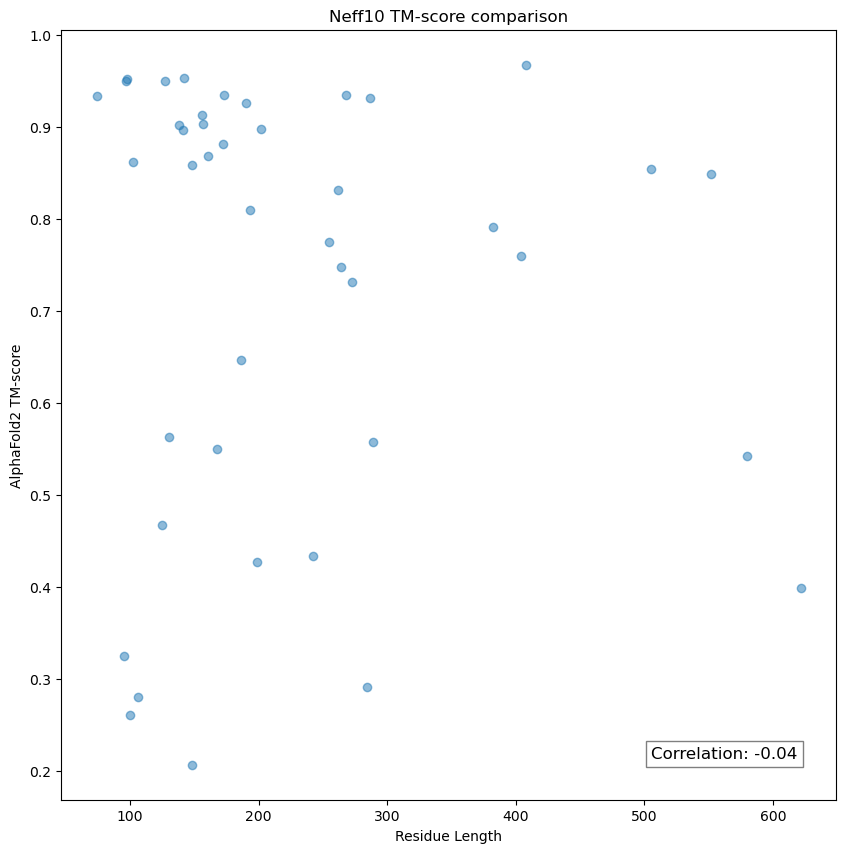

In [17]:
# 데이터 준비
neff10_Alphalink_result, neff10_AlphaFold2_result = neff10[9].values, neff10[10].values

alphalink = {}
alphafold2 = {}
for i in range(len(neff10_Alphalink_result)):
    alphalink_result = neff10_Alphalink_result[i]
    alphafold_result = neff10_AlphaFold2_result[i]
    
    target = alphalink_result.split('_')[0][1:]
    if target not in residue_lengths.keys():
        continue
    
    alphalink_tmscore = float(alphalink_result.split('_')[-1].split('=')[-1])
    alphafold2_tmscore = float(alphafold_result.split('_')[-1].split('=')[-1])
    
    alphalink[target] = alphalink_tmscore
    alphafold2[target] = alphafold2_tmscore

sizes = [residue_lengths[key] for key in alphafold2.keys()]

# 상관계수 계산
correlation_coef = np.corrcoef(sizes, list(alphafold2.values()))[0, 1]

# 플롯 그리기
plt.figure(figsize=(10, 10))
plt.title('Neff10 TM-score comparison')
scatter = plt.scatter(sizes, list(alphafold2.values()), alpha=0.5)
plt.xlabel('Residue Length')
plt.ylabel('AlphaFold2 TM-score')

# 상관계수를 플롯의 우측 상단에 표시
plt.text(0.95, 0.05, f'Correlation: {correlation_coef:.2f}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', 
         horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))

plt.show()